# US data + extrapolation (test notebook)

In [2]:
import os
import json
import pickle
import numpy as np
import pandas as pd
import urllib.request

import datetime
from datetime import datetime

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import clear_output, display

### Just some matplotlib and seaborn parameter tuning

In [3]:
out = './out/'
figsave_format = 'png'
figsave_dpi = 200
pad_inches = 0.15

# Axis size parameters
fig_x = 17
fig_y = 11
axistitlesize = 22
axisticksize_date = 13
axisticksize_y = 18
axislabelsize = 30
axistextsize = 14
axislegendsize = 20

# "Source text" position
text_x = 0.16
text_y = -0.15

# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

mpl.rcParams.update({'figure.autolayout': False})

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

# Colors
cases_color = 'yellow'
recov_color = 'darkturquoise'
death_color = 'tab:red'

## Load and preprocess pandemic data

In [5]:
url_US_cases = (
    'https://raw.githubusercontent.com/' +
    'CSSEGISandData/COVID-19/' +
    'master/' +
    'csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
)
url_US_death = (
    'https://raw.githubusercontent.com/' +
    'CSSEGISandData/COVID-19/' +
    'master/' +
    'csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
)

In [6]:
# Load .csv formatted datafiles
with urllib.request.urlopen(url_US_cases) as url:
    data_US_cases = pd.read_csv(url, sep=',', comment='#', header=0)
with urllib.request.urlopen(url_US_death) as url:
    data_US_death = pd.read_csv(url, sep=',', comment='#', header=0)

### Prepare date format

In [7]:
from matplotlib import ticker
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

In [8]:
date_format = mdates.DateFormatter('%b %d \'%y')

In [17]:
def create_date_ticks(dates):
    # Empirical observation, that 22 x-ticks should be on the figures to look nicely
    N = 22
    step_size = int(len(dates) / N)
    date_ticks = np.append(dates[:-int(step_size/1.4):step_size], dates[-1])
    
    return date_ticks

In [18]:
date_cols = data_US_cases.columns[11:]
dates = np.array([datetime.strptime(d, '%m/%d/%y') for d in date_cols])
date_ticks = create_date_ticks(dates)

### Aggregate datasets

In [19]:
data_US_cases = data_US_cases.groupby(by='Province_State', group_keys=False).agg('sum')[date_cols]
data_US_death = data_US_death.groupby(by='Province_State', group_keys=False).agg('sum')[date_cols]

## Case number plots

In [24]:
def plot_us_region(region, mode='full'):
    
    nrows = 1
    ncols = 1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*fig_x, nrows*fig_y),
                             facecolor='black', subplot_kw=dict(facecolor='black'))

    if mode.lower()=='full':
        axes.plot(dates, data_US_cases.loc[region], label='Confirmed',
                  c=cases_color, lw=3)
        axes.fill_between(dates, data_US_cases.loc[region], color=cases_color, alpha=0.5)

        axes.plot(dates, data_US_death.loc[region], label='Deaths',
                  c=death_color, lw=3)
        axes.fill_between(dates, data_US_death.loc[region], color=death_color, alpha=0.5)
        
        axes.set_title('COVID-19 Official number of historical cases - {}'.format(region), 
                   fontsize=axistitlesize, fontweight='bold', color='white')

    elif mode.lower()=='total':
        region_total = data_US_cases.loc[region] - data_US_death.loc[region]
        axes.plot(dates, region_total, label='Active total',
                  c=cases_color, lw=3)
        axes.fill_between(dates, region_total, color=cases_color, alpha=0.5)
        
        axes.set_title('COVID-19 Official number of active cases - {}'.format(region), 
                   fontsize=axistitlesize, fontweight='bold', color='white')
    
    elif mode.lower()=='daily':
        region_daily = np.zeros_like(data_US_cases.loc[region])
        
        # Set starting day value
        region_daily[0] = 0
        for i in range(len(data_US_cases.loc[region][1:])):
            now = data_US_cases.loc[region][i+1]
            prev = data_US_cases.loc[region][i]
            
            region_daily[i+1] = now - prev
            
        axes.plot(dates, region_daily, label='Daily',
              c=cases_color, lw=3)
        axes.fill_between(dates, region_daily, color=cases_color, alpha=0.5)

        axes.set_title('COVID-19 Official number of daily cases - {}'.format(region), 
                   fontsize=axistitlesize, fontweight='bold', color='white')
        
    else:
        raise AttributeError('Modes should be \'total\' or \'full\'')
        
    # Source text
    axes.text(x=text_x, y=text_y, s='Source of data: https://github.com/CSSEGISandData/COVID-19/',
              c='white', fontsize=axistextsize, fontweight='book',
              horizontalalignment='center', verticalalignment='center', transform=axes.transAxes,
              bbox=dict(facecolor='black', alpha=0.2, lw=0))

    # X-AXIS FORMATTING
    axes.set_xlabel('Time', fontsize=axislabelsize, fontweight='bold', color='white')
    axes.tick_params(axis='x', which='major', labelsize=axisticksize_date, colors='white')
    axes.set_xticks(date_ticks)
    axes.set_xticklabels(date_ticks, rotation=62, ha='center')
    axes.xaxis.set_major_formatter(date_format)
    axes.set_xlim(dates[0], dates[-1])

    # Y-AXIS FORMATTING
    axes.set_ylabel('Number of cases', fontsize=axislabelsize, fontweight='bold', color='white')
    axes.tick_params(axis='y', which='major', labelrotation=42, labelsize=axisticksize_y, colors='white')
    axes.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1e}"))

    axes.legend(loc='upper left', fontsize=axislegendsize)

    plt.savefig(out + 'time_series_{0}_{1}.png'.format(region.lower().replace(' ', ''), mode.lower()),
                format=figsave_format, dpi=figsave_dpi,
                pad_inches=pad_inches,
                facecolor='black', edgecolor='black')

    plt.show()

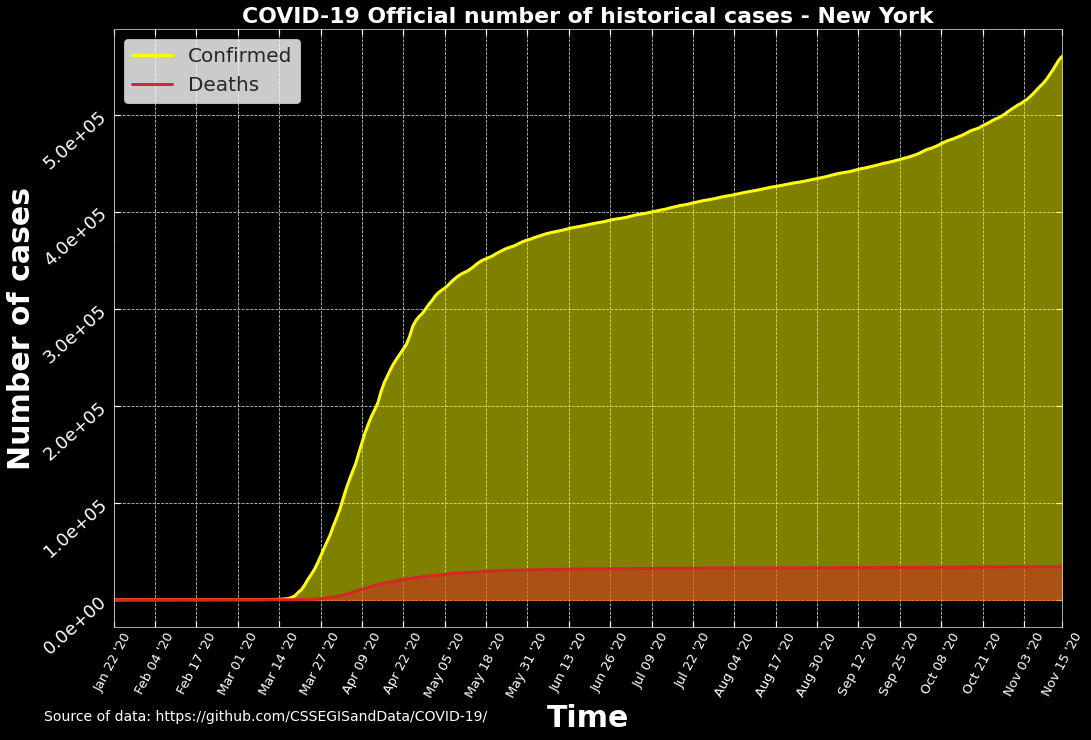

In [25]:
plot_us_region(region='New York', mode='full')

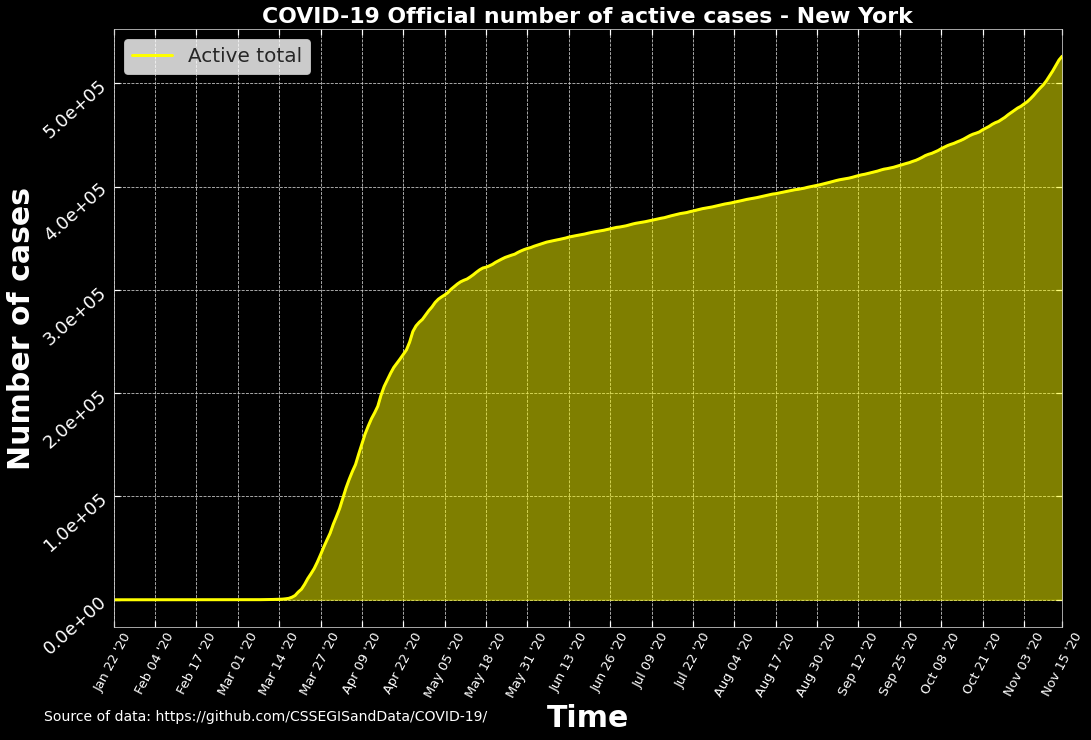

In [27]:
plot_us_region(region='New York', mode='total')

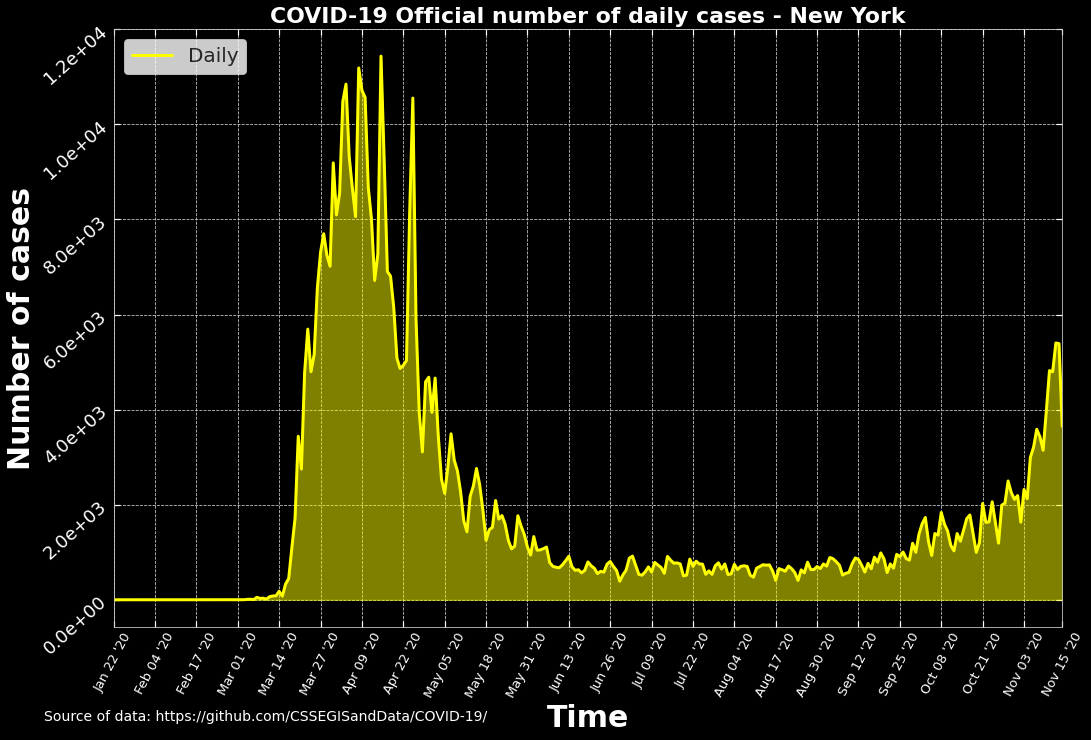

In [26]:
plot_us_region(region='New York', mode='daily')

## Simple extrapolation using logistic fitting

In [52]:
from scipy.optimize import curve_fit

### Logistic curve fitting on available data

In [53]:
def logistic_p0(X, Y): 
    
    L = np.max(Y)
    k = 1
    x_0 = np.median(X)
    y_0 = np.min(Y)
    
    return [L, k, x_0, y_0]

In [54]:
def logistic(X, L, k, x_0, y_0):
    
    return L / (1 + np.exp(-k * (X - x_0))) + y_0

In [55]:
def pred_region(region):

    N = len(dates)
    X = np.linspace(0, N-1, N)
    Y = region_cases.loc[region]

    p0 = logistic_p0(X, Y)
    popt, pcov = curve_fit(logistic, X, Y, p0)
    
    return popt, pcov

In [56]:
def pred_US_region(region):

    N = len(dates)
    X = np.linspace(0, N-1, N)
    Y = data_US_cases.loc[region]

    p0 = logistic_p0(X, Y)
    popt, pcov = curve_fit(logistic, X, Y, p0)
    
    return popt, pcov

In [57]:
def pred_all():
    
    N = len(dates)
    X = np.linspace(0, N-1, N)
    Y = sum_cases_adj

    p0 = logistic_p0(X, Y)
    popt, pcov = curve_fit(logistic, X, Y, p0)
    
    return popt, pcov

### Plotting prediction using fitted curve

In [58]:
def add_days(dates, add):
    last_date = dates[-1].split('/')
    current = datetime.datetime(int('20' + last_date[2]), int(last_date[0]), int(last_date[1]))
    
    raw_dates = [current + datetime.timedelta(days=d) for d in range(1, add+1)]
    form_dates = [str(date.month) + '/' + str(date.day) + '/' + str(date.year)[2:] for date in raw_dates]
    pred_dates = np.append(dates, form_dates)
    
    return pred_dates

In [59]:
def plot_pred_all(popt, pred_N=1.4):
    
    nrows = 1
    ncols = 1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*14, nrows*11),
                             facecolor='black', subplot_kw=dict(facecolor='black'))
    
    # Current data
    cases_color = 'yellow'
    axes.plot(dates, sum_cases_adj, label='Confirmed',
              c=cases_color, lw=3)
    # Mark last real datapoint
    axes.axvline(x=dates[-1], c=cases_color, lw=2, ls='--')
    
    # Predicted data
    N = len(dates)
    pred_dates = add_days(dates, add=int(np.round(N*pred_N)) - N)
    pred_X = np.linspace(0, int(np.round(pred_N*(N-1))), int(np.round(pred_N*N)))
    axes.plot(pred_dates, logistic(pred_X, *popt), label='Logistic prediction',
              c='tab:red', lw=4, alpha=0.7)

    axes.set_title('COVID-19 Predicted number of cases', 
                   fontsize=axistitlesize, fontweight='bold', color='white')
    
    # Source text
    axes.text(x=0.16, y=-0.12, s='Source of data: https://github.com/CSSEGISandData/COVID-19/',
              c='white', fontsize=13, fontweight='book',
              horizontalalignment='center', verticalalignment='center', transform=axes.transAxes,
              bbox=dict(facecolor='black', alpha=0.2, lw=0))

    axes.set_xlabel('Time', fontsize=axislabelsize, color='white')
    axes.set_ylabel('Number of cases', fontsize=axislabelsize, color='white')

    axes.tick_params(axis='both', which='major', labelsize=axisticksize, colors='white')
    axes.set_xticks(pred_dates[::int(np.round(pred_N))*date_jump])
    axes.set_xticklabels(pred_dates[::int(np.round(pred_N))*date_jump], rotation=42, ha='center')

    # Should be placed after setting x-ticks!!!
    axes.set_xlim(pred_dates[0], pred_dates[-1])

    axes.legend(loc='upper left', fontsize=axislegendsize)

    plt.show()

In [60]:
def plot_pred_region(region, popt, pred_N=1.4):
    
    nrows = 1
    ncols = 1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*14, nrows*11),
                             facecolor='black', subplot_kw=dict(facecolor='black'))
    
    # Current data
    cases_color = 'yellow'
    axes.plot(dates, region_cases.loc[region], label='Confirmed',
              c=cases_color, lw=3)
    # Mark last real datapoint
    axes.axvline(x=dates[-1], c=cases_color, lw=2, ls='--')
    
    # Predicted data
    N = len(dates)
    pred_dates = add_days(dates, add=int(np.round(N*pred_N)) - N)
    pred_X = np.linspace(0, int(np.round(pred_N*(N-1))), int(np.round(pred_N*N)))
    axes.plot(pred_dates, logistic(pred_X, *popt), label='Logistic prediction',
              c='tab:red', lw=4, alpha=0.7)

    axes.set_title('COVID-19 Predicted number of cases - {}'.format(region), 
                   fontsize=axistitlesize, fontweight='bold', color='white')
    
    # Source text
    axes.text(x=0.16, y=-0.12, s='Source of data: https://github.com/CSSEGISandData/COVID-19/',
              c='white', fontsize=13, fontweight='book',
              horizontalalignment='center', verticalalignment='center', transform=axes.transAxes,
              bbox=dict(facecolor='black', alpha=0.2, lw=0))

    axes.set_xlabel('Time', fontsize=axislabelsize, color='white')
    axes.set_ylabel('Number of cases', fontsize=axislabelsize, color='white')

    axes.tick_params(axis='both', which='major', labelsize=axisticksize, colors='white')
    axes.set_xticks(pred_dates[::int(np.round(pred_N))*date_jump])
    axes.set_xticklabels(pred_dates[::int(np.round(pred_N))*date_jump], rotation=42, ha='center')

    # Should be placed after setting x-ticks!!!
    axes.set_xlim(pred_dates[0], pred_dates[-1])

    axes.legend(loc='upper left', fontsize=axislegendsize)

    plt.show()

NameError: name 'date_jump' is not defined

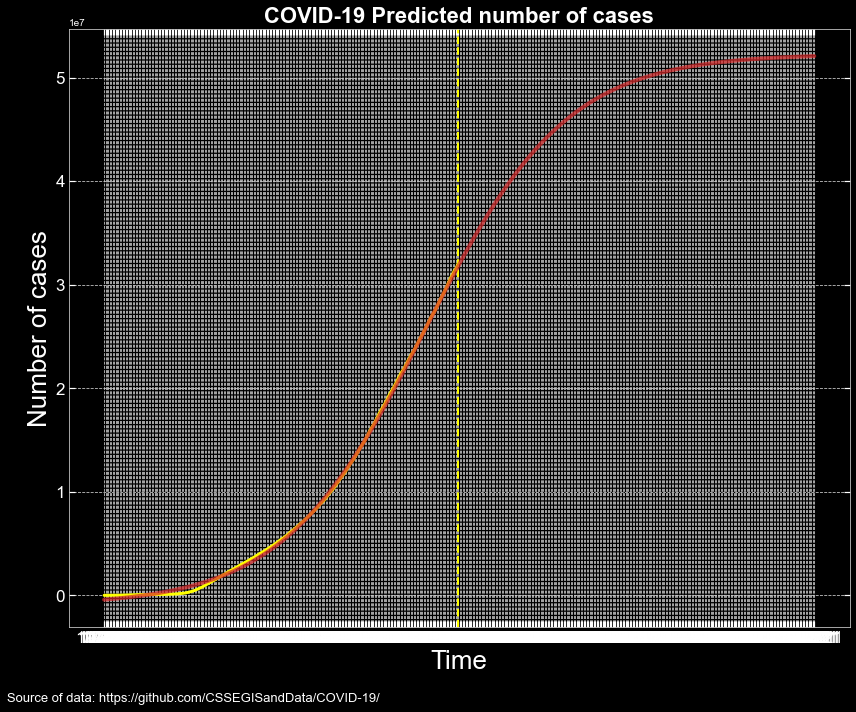

In [61]:
popt, pcov = pred_all()
plot_pred_all(popt, pred_N=2)

In [ ]:
region = 'Hungary'
popt, pcov = pred_region(region)
plot_pred_region(region, popt, pred_N=2)

## Retarded Polyfit

In [ ]:
def plot_pred_US_region(region, popt, pred_N=1.4):
    
    nrows = 1
    ncols = 1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*14, nrows*11),
                             facecolor='black', subplot_kw=dict(facecolor='black'))
    
    # Current data
    cases_color = 'yellow'
    axes.plot(dates, data_US_cases.loc[region], label='Confirmed',
              c=cases_color, lw=3)
    # Mark last real datapoint
    axes.axvline(x=dates[-1], c=cases_color, lw=2, ls='--')
    
    # Predicted data
    N = len(dates)
    pred_dates = add_days(dates, add=int(np.round(N*pred_N)) - N)
    pred_X = np.linspace(0, int(np.round(pred_N*(N-1))), int(np.round(pred_N*N)))
    axes.plot(pred_dates, logistic(pred_X, *popt), label='Logistic prediction',
              c='tab:red', lw=4, alpha=0.7)

    axes.set_title('COVID-19 Predicted number of cases - {}'.format(region), 
                   fontsize=axistitlesize, fontweight='bold', color='white')
    
    # Source text
    axes.text(x=0.16, y=-0.12, s='Source of data: https://github.com/CSSEGISandData/COVID-19/',
              c='white', fontsize=13, fontweight='book',
              horizontalalignment='center', verticalalignment='center', transform=axes.transAxes,
              bbox=dict(facecolor='black', alpha=0.2, lw=0))

    axes.set_xlabel('Time', fontsize=axislabelsize, color='white')
    axes.set_ylabel('Number of cases', fontsize=axislabelsize, color='white')

    axes.tick_params(axis='both', which='major', labelsize=axisticksize, colors='white')
    axes.set_xticks(pred_dates[::int(np.round(pred_N))*date_jump])
    axes.set_xticklabels(pred_dates[::int(np.round(pred_N))*date_jump], rotation=42, ha='center')

    # Should be placed after setting x-ticks!!!
    axes.set_xlim(pred_dates[0], pred_dates[-1])

    axes.legend(loc='upper left', fontsize=axislegendsize)

    plt.show()

In [ ]:
region = 'New York'
popt, pcov = pred_US_region(region)
plot_pred_US_region(region, popt, pred_N=2)